# FA24 - Assignment 4 - **Image Segmentation**

Instructions
* Download the `.zip` folders from Moodle.
* Do **NOT** forget to type in your name and AUBNET after this cell.
* Do **NOT** upload the dataset with your submission.
* **If an assignment contains a copied solution, the entire assignment will be awarded 0 points for all individuals submitting the same solution. Furthermore, any solutions generated by AI tools, will also receive 0 points.**
* Name the assignment as follows: **Image_Segmentation_AUBNET.ipynb** . Failure to follow this naming convention will result in the notebook **not being graded**.
* Notebooks with no output will not be graded
* You are not allowed to Add, Edit, or delete any of the given headers/ Libraries.

**CMPS 364 - Advanced Machine Learning**

**Assignment 4 Part I - Computer Vision - Image Segmentation**

**By - Ralph Mouawad - rmm85 - 202204667**

**To - Dr. Shady Elbassuoni**

# Introduction

In semantic segmentation, each pixel in an image is classified into a specific category, making it essentially a pixel-wise classification task. Fine-tuning a pre-trained model is particularly useful when labeled data is limited.

For this example, we’ll use a model pre-trained on the Microsoft COCO dataset and adapt it to perform segmentation for new classes it hasn’t seen before. Specifically, we’ll fine-tune the DeepLabV3 model on a flower dataset.


### Download dataset and initialize DataLoader

Download the datasets on moodle and extract them


In [1]:
!tar xvzf small_flowers.tgz
!tar xvzf maps.tgz

jpg/files.txt
jpg/files.txt~
jpg/image_0001.jpg
jpg/image_0002.jpg
jpg/image_0003.jpg
jpg/image_0004.jpg
jpg/image_0005.jpg
jpg/image_0006.jpg
jpg/image_0007.jpg
jpg/image_0008.jpg
jpg/image_0009.jpg
jpg/image_0010.jpg
jpg/image_0011.jpg
jpg/image_0012.jpg
jpg/image_0013.jpg
jpg/image_0014.jpg
jpg/image_0015.jpg
jpg/image_0016.jpg
jpg/image_0017.jpg
jpg/image_0018.jpg
jpg/image_0019.jpg
jpg/image_0020.jpg
jpg/image_0021.jpg
jpg/image_0022.jpg
jpg/image_0023.jpg
jpg/image_0024.jpg
jpg/image_0025.jpg
jpg/image_0026.jpg
jpg/image_0027.jpg
jpg/image_0028.jpg
jpg/image_0029.jpg
jpg/image_0030.jpg
jpg/image_0031.jpg
jpg/image_0032.jpg
jpg/image_0033.jpg
jpg/image_0034.jpg
jpg/image_0035.jpg
jpg/image_0036.jpg
jpg/image_0037.jpg
jpg/image_0038.jpg
jpg/image_0039.jpg
jpg/image_0040.jpg
jpg/image_0041.jpg
jpg/image_0042.jpg
jpg/image_0043.jpg
jpg/image_0044.jpg
jpg/image_0045.jpg
jpg/image_0046.jpg
jpg/image_0047.jpg
jpg/image_0048.jpg
jpg/image_0049.jpg
jpg/image_0050.jpg
jpg/image_0051.jpg
jp

## Helper code
The following functions are provided to assist with dataset setup and visualization.

In [2]:
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from scipy.io import loadmat

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset

### Data Reading and Normalization

In [3]:
# Dataset helper function
def read_img(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)


def normalize(im):
    img_net_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return (im / 255.0 - img_net_stats[0]) / img_net_stats[1]


def denormalize(img):
    img_net_stats = np.array([[0.485, 0.456, 0.406], [0.229, 0.224, 0.225]])
    return img * img_net_stats[1] + img_net_stats[0]

class Data(Dataset):
    def __init__(self, files_path, split, train=True):

        self.files_path = files_path
        self.split = split
        if train:
            filenames = (
                list(self.split["trn1"][0])
                + list(self.split["trn2"][0])
                + list(self.split["trn3"][0])
            )
        else:
            # We only use `val1` for validation
            filenames = self.split["val1"][0]

        valid_filenames = []
        for i in filenames:
            img_name = "image_%04d.jpg" % int(i)
            if os.path.exists(os.path.join(files_path, "jpg", img_name)) and os.path.exists(
                os.path.join(files_path, "trimaps", img_name.replace("jpg", "png"))
            ):
                valid_filenames.append(img_name)

        self.valid_filenames = valid_filenames
        self.num_files = len(valid_filenames)

    def __len__(self):
        return self.num_files

    def __getitem__(self, index):

        filename = self.valid_filenames[index]

        # Load the image
        path = os.path.join(self.files_path, "jpg", filename)
        x = read_img(path)  # H*W*c
        x = cv2.resize(x, (224, 224))
        x = normalize(x)
        x = np.rollaxis(x, 2)  # To meet torch's input specification(c*H*W)

        # Load the segmentation mask
        path = os.path.join(self.files_path, "trimaps", filename.replace("jpg", "png"))
        y = read_img(path)
        y = cv2.resize(y, (224, 224))  # H*W*c

        return x, y


def init_loader(batch_size_train=64, batch_size_val=64):
    split = loadmat("Splits.mat")
    train_dataset = Data("./", split, train=True)
    valid_dataset = Data("./", split, train=False)
    loader_train = DataLoader(
        train_dataset, batch_size=batch_size_train, shuffle=True, num_workers=4, drop_last=True
    )
    loader_valid = DataLoader(valid_dataset, batch_size=batch_size_val, num_workers=4)
    return loader_train, loader_valid

### Data Visualization

In [4]:
def plot_dataset(loader):
    x, y = next(iter(loader))

    fig = plt.figure(figsize=(10, 5))
    for i in range(4):
        inp = x[i]
        inp = inp.numpy().transpose(1, 2, 0)
        inp = denormalize(inp)
        mask = y[i] / 255.0

        ax = fig.add_subplot(2, 2, i + 1, xticks=[], yticks=[])
        plt.imshow(np.concatenate([inp, mask], axis=1))


def plot_pred(args, model, is_train, index_list=[0], plot_path=None, title=None):

    loader_train, loader_valid = init_loader()
    loader = loader_train if is_train else loader_valid

    images, masks = next(iter(loader))
    images = images.float()
    if args.gpu:
        images = images.cuda()

    with torch.no_grad():
        outputs = model(images)["out"]
    output_predictions = outputs.argmax(1)

    # create a color pallette, selecting a color for each class
    palette = torch.tensor([2 ** 25 - 1, 2 ** 15 - 1, 2 ** 21 - 1])
    colors = torch.as_tensor([i for i in range(21)])[:, None] * palette
    colors = (colors % 255).numpy().astype("uint8")
    colors = [i for color in colors for i in color]

    for index in index_list:

        r = Image.fromarray(output_predictions[index].byte().cpu().numpy())
        r.putpalette(colors)

        fig = plt.figure(figsize=(10, 5))
        if title:
            plt.title(title)

        ax = fig.add_subplot(1, 3, 1, xticks=[], yticks=[])
        plt.imshow(denormalize(images[index].cpu().numpy().transpose(1, 2, 0)))

        ax = fig.add_subplot(1, 3, 2, xticks=[], yticks=[])
        plt.imshow(r)

        ax = fig.add_subplot(1, 3, 3, xticks=[], yticks=[])
        plt.imshow(masks[index])

        if plot_path:
            plt.savefig(plot_path)
            plt.close()

Execute the code below to initialize the `DataLoader` and visualize a few examples.

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


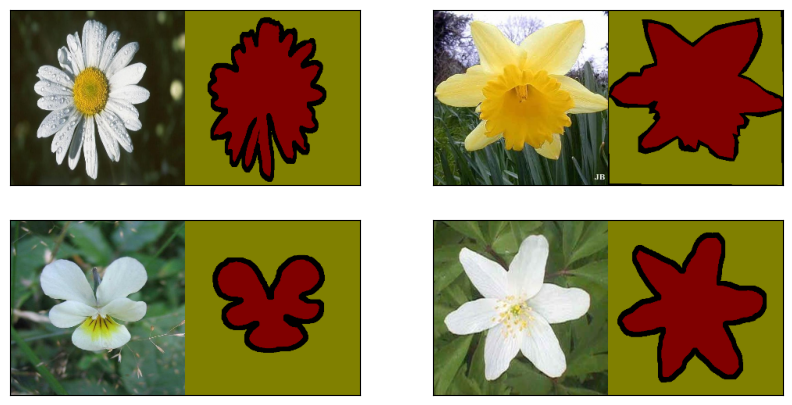

In [5]:
loader_train, loader_valid = init_loader()
plot_dataset(loader_train)

### Load Pre-Trained Model

PyTorch [Hub](https://pytorch.org/docs/stable/hub.html) llows you to publish pre-trained models, including their definitions and weights, to a GitHub repository by adding a simple hubconf.py file. Use the code below to download [deeplabv3](https://arxiv.org/pdf/1706.05587.pdf).

In [16]:
import torch
import torchvision
from torchvision.models.segmentation import deeplabv3_resnet101

# Load the model using current API with weights parameter
# model = deeplabv3_resnet101()
model = deeplabv3_resnet101(pretrained=True)

# or if you want to use the newer DEFAULT weights:
# model = deeplabv3_resnet101(weights='DEFAULT')

print(model)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DeepLabV3_ResNet101_Weights.COCO_WITH_VOC_LABELS_V1`. You can also use `weights=DeepLabV3_ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth
100%|██████████| 233M/233M [00:01<00:00, 150MB/s]


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

### Training Helper Functions

Here are some functions that will assist with the model training process.

In [17]:
def calc_loss(pred, gt):
    loss = F.cross_entropy(pred, gt)
    return loss


# from https://www.kaggle.com/iezepov/fast-iou-scoring-metric-in-pytorch-and-numpy
def iou_metric(outputs, labels):

    sm = 1e-6
    # You can comment out this line if you are passing tensors of the same shape.
    # However, if you're passing output from a UNet or similar model, it will likely
    # have the shape BATCH x 1 x H x W.
    outputs = torch.argmax(outputs, 1)
    outputs = outputs.squeeze(1)  # Convert from shape BATCH x 1 x H x W to BATCH x H x W

    intersection = (outputs & labels).float().sum((1, 2)) # Will be zero if either Truth = 0 or Prediction = 0
    union = (outputs | labels).float().sum((1, 2))  # Will be zero if both values are 0

    iou = (intersection + sm) / (union + sm) # Apply smoothing to avoid division by zero

    thresholded = (
        torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    )  # This is equivalent to comparing with thresholds

    return (
        thresholded.mean()
    )  # Alternatively, use thresholded.mean() if you want the average across the batch


def convert_to_binary(masks, thres=0.5):
    binary_masks = (
        (masks[:, 0, :, :] == 128) & (masks[:, 1, :, :] == 0) & (masks[:, 2, :, :] == 0)
    ) + 0.0
    return binary_masks.long()

def run_validation_step(args, epoch, model, loader, plot_path=None):

    model.eval()  # Set the model to 'eval' mode (BatchNorm layers will use moving mean/variance).

    losses = []
    ious = []
    with torch.no_grad():
        for i, (images, masks) in enumerate(loader):
            permute_masks = masks.permute(0, 3, 1, 2)  # Adjust to match the input size: B x C x H x W
            binary_masks = convert_to_binary(permute_masks)
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()
            output = model(images.float())
            pred_seg_masks = output["out"]

            output_predictions = pred_seg_masks[0].argmax(0)
            if args.loss == 'cross-entropy':
                loss = calc_loss(pred_seg_masks, binary_masks)
            else:
                loss = compute_iou_loss(pred_seg_masks, binary_masks)
            iou = iou_metric(pred_seg_masks, binary_masks)
            losses.append(loss.data.item())
            ious.append(iou.data.item())

        val_loss = np.mean(losses)
        val_iou = np.mean(ious)

    if plot_path:
        plot_pred(
            args, model, False, index_list=[0], plot_path=plot_path, title="Val_%d" % epoch
        )

    return val_loss, val_iou

 ## Fine-tuning the Semantic Segmentation Model with Cross-Entropy Loss

### Question 1.

In this assignment, we aim to fine-tune only the last layer of the downloaded DeepLabV3 model. We achieve this by tracking the weights we wish to update in the variable  `learned_parameters`.
            
Utilize the PyTorch utility [`Model.named_parameters()`](https://pytorch.org/docs/stable/nn.html), which provides an iterator over all the model's weight matrices.

The weights of the last layer are prefixed with `classifier.4`. We will select these weights and pass them to `learned_parameters`.  
            
Complete the `train` function by adding three lines of code at the specified location.

In [18]:
def train(args, model):

    # Limit the maximum number of threads to prevent crashes in Teaching Labs
    torch.set_num_threads(5)
    np.random.seed(args.seed)

    # Define save directory
    # Create the 'outputs' folder if it doesn’t already exist
    save_dir = "outputs/" + args.exp_name
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    learned_parameters = []
    # Only train the last layer while freezing all other weights
    ################ Code goes here ######################
    # Around 3 lines of code
    # Hint:
    # - Use a for loop to iterate over all model.named_parameters()
    # - Append the parameters (weights and biases) of the last layer (prefix: classifier.4) to the learned_parameters list
    ######################################################
    for name, param in model.named_parameters():
        if name.startswith('classifier.4'):
            learned_parameters.append(param)

    # Adam optimizer will only update the learned_parameters
    optimizer = torch.optim.Adam(learned_parameters, lr=args.learning_rate)

    loader_train, loader_valid = init_loader(args.batch_size_train, args.batch_size_val)
    print(
        "Train set: {}, Test set: {}".format(
            loader_train.dataset.num_files, loader_valid.dataset.num_files
        )
    )

    print("Beginning training ...")
    if args.gpu:
        model.cuda()

    start = time.time()
    training_losses = []
    validation_losses = []
    validation_ious = []
    best_mean_iou = 0

    for epoch in range(args.epochs):

        # Train the Model
        model.train()  # Change model to 'train' mode
        start_tr = time.time()

        losses = []
        for i, (images, masks) in enumerate(loader_train):
            permute_masks = masks.permute(0, 3, 1, 2)  # to match the input size: B, C, H, W
            binary_masks = convert_to_binary(permute_masks)  # B, H, W
            if args.gpu:
                images = images.cuda()
                binary_masks = binary_masks.cuda()

            # Forward + Backward + Optimize
            optimizer.zero_grad()
            output = model(images.float())
            pred_seg_masks = output["out"]

            _, pred_labels = torch.max(pred_seg_masks, 1, keepdim=True)
            if args.loss == 'cross-entropy':
                loss = calc_loss(pred_seg_masks, binary_masks)
            else:
                loss = compute_iou_loss(pred_seg_masks, binary_masks)
            loss.backward()
            optimizer.step()
            losses.append(loss.data.item())

        # plot training images
        if args.plot:
            plot_pred(
                args,
                model,
                True,
                index_list=[0],
                plot_path=save_dir + "/train_%d.png" % epoch,
                title="Train_%d" % epoch,
            )

        # plot training images
        trn_loss = np.mean(losses)
        training_losses.append(trn_loss)
        time_elapsed = time.time() - start_tr
        print(
            "Epoch [%d/%d]: Loss = %.4f, Time (seconds) = %d"
            % (epoch + 1, args.epochs, trn_loss, time_elapsed)
        )

        # Evaluate the model
        start_val = time.time()
        val_loss, val_iou = run_validation_step(
            args, epoch, model, loader_valid, save_dir + "/val_%d.png" % epoch
        )

        if val_iou > best_mean_iou:
            best_mean_iou = val_iou
            torch.save(
                model.state_dict(), os.path.join(save_dir, args.checkpoint_name + "-best.ckpt")
            )

        time_elapsed = time.time() - start_val
        print(
            "Epoch [%d/%d]: Loss = %.4f, mean IoU = %.4f, Validation Time (seconds) = %d"
            % (epoch + 1, args.epochs, val_loss, val_iou, time_elapsed)
        )

        validation_losses.append(val_loss)
        validation_ious.append(val_iou)

    # Plot training curve
    plt.figure()
    plt.plot(training_losses, "ro-", label="Training Loss")
    plt.plot(validation_losses, "go-", label="Validation Loss")
    plt.legend()
    plt.title("Training and Validation Loss Over Epochs")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/loss_curve.png")

    # Plot validation IoU curve
    plt.figure()
    plt.plot(validation_ious, "ro-", label="Mean IoU")
    plt.legend()
    plt.title("Mean IoU Over Epochs")
    plt.xlabel("Epochs")
    plt.savefig(save_dir + "/mean_iou_curve.png")

    print("Saving model...")
    torch.save(
        model.state_dict(),
        os.path.join(save_dir, args.checkpoint_name + "-{}-lastpoint.ckpt".format(args.epochs)),
    )

    print("Best model attains a mean IoU of: %.4f" % best_mean_iou)

### Question 2.

For fine-tuning, we also want to:

*	Utilize `Model.requires_grad_()` to prevent backpropagation through all the layers that should remain frozen.
*	Replace the last layer with a new `nn.Conv2d` layer that has the appropriate input and output channels as well as kernel sizes. Since this assignment focuses on binary segmentation, the new layer should have two output channels.

Complete the script below by adding approximately four lines of code to train the model.

Train set: 1280, Test set: 212
Beginning training ...


Epoch [1/10]: Loss = 0.8593, Time (seconds) = 49


Epoch [1/10]: Loss = 0.6779, mean IoU = 0.0604, Validation Time (seconds) = 13
Epoch [2/10]: Loss = 0.5447, Time (seconds) = 50


Epoch [2/10]: Loss = 0.4210, mean IoU = 0.1934, Validation Time (seconds) = 12


Epoch [3/10]: Loss = 0.4020, Time (seconds) = 49


Epoch [3/10]: Loss = 0.3188, mean IoU = 0.2689, Validation Time (seconds) = 13


Epoch [4/10]: Loss = 0.3483, Time (seconds) = 49


Epoch [4/10]: Loss = 0.3063, mean IoU = 0.2623, Validation Time (seconds) = 11


Epoch [5/10]: Loss = 0.3225, Time (seconds) = 48


Epoch [5/10]: Loss = 0.3096, mean IoU = 0.2561, Validation Time (seconds) = 12


Epoch [6/10]: Loss = 0.3069, Time (seconds) = 49


Epoch [6/10]: Loss = 0.2899, mean IoU = 0.2939, Validation Time (seconds) = 12


Epoch [7/10]: Loss = 0.2978, Time (seconds) = 49


Epoch [7/10]: Loss = 0.2784, mean IoU = 0.3127, Validation Time (seconds) = 13


Epoch [8/10]: Loss = 0.2938, Time (seconds) = 50


Epoch [8/10]: Loss = 0.2760, mean IoU = 0.3401, Validation Time (seconds) = 12


Epoch [9/10]: Loss = 0.2894, Time (seconds) = 49


Epoch [9/10]: Loss = 0.2701, mean IoU = 0.3307, Validation Time (seconds) = 12


Epoch [10/10]: Loss = 0.2893, Time (seconds) = 49


Epoch [10/10]: Loss = 0.2685, mean IoU = 0.3250, Validation Time (seconds) = 11
Saving model...
Best model attains a mean IoU of: 0.3401


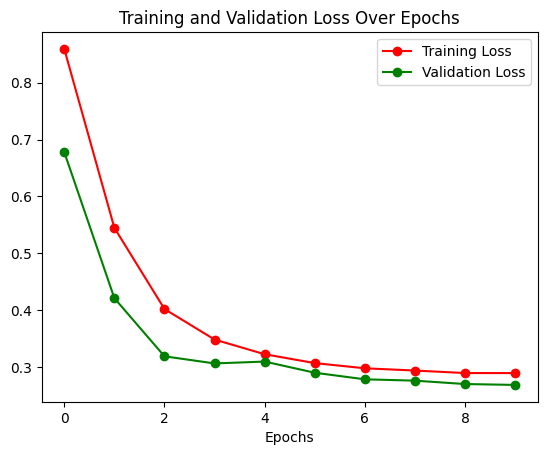

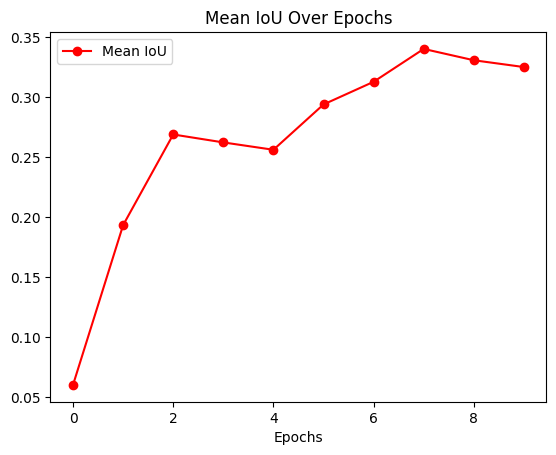

In [19]:
class AttrDictionary(dict):
    def __init__(self, *args, **kwargs):
        super(AttrDictionary, self).__init__(*args, **kwargs)
        self.__dict__ = self

args = AttrDictionary()
# You can experiment with the hyperparameters here, but tuning them is not necessary to complete the assignment.
args_dict_param = {
    "gpu": True,
    "checkpoint_name": "seg",
    "learning_rate": 0.05,
    "batch_size_train": 128,
    "batch_size_val": 256,
    "epochs": 10,
    "loss": 'cross-entropy',
    "seed": 0,
    "plot": True,
    "exp_name": "seg",
}
args.update(args_dict_param)

# Remove the last layer and substitute it with a new one.
# To prevent 'CUDA out of memory' errors, it may be helpful (and sometimes essential)
# to set `requires_grad=False` for certain layers.
######################################################
# Approximately 4 lines of code
# Hint:
# - Replace the classifier.4 layer with the new Conv2d layer (1 line)
# - The aux_classifier module can be ignored (consider it irrelevant)
# - Freeze the gradients for the remaining layers (3 lines)
######################################################
#############################
### Your code starts here ###
#############################

# modify the layer
model.classifier[4] = nn.Conv2d(
    in_channels = model.classifier[4].in_channels,
    out_channels = 2,
    kernel_size = model.classifier[4].kernel_size,
    stride = model.classifier[4].stride,
    padding = model.classifier[4].padding
)

# freeze gradients
for name, param in model.named_parameters():
  if not name.startswith('classifier'): # freeze all parameters except those of last layer
    param.requires_grad = False

model.requires_grad_(False)
model.classifier[4].requires_grad_(True)

train(args, model)

#############################
### Your code ends here ###
#############################

### Question 3.

Visualize the predictions by executing the code below.

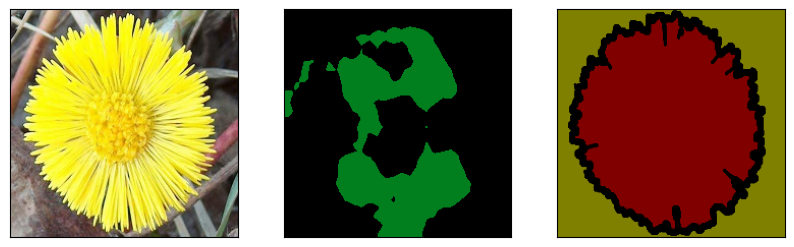

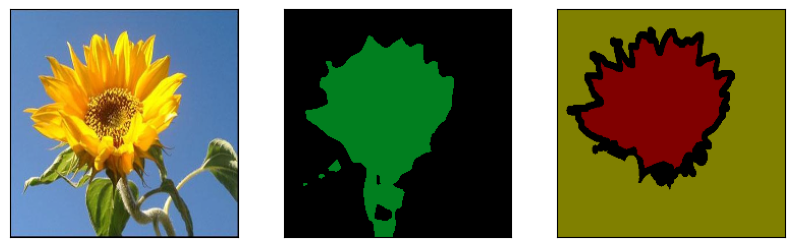

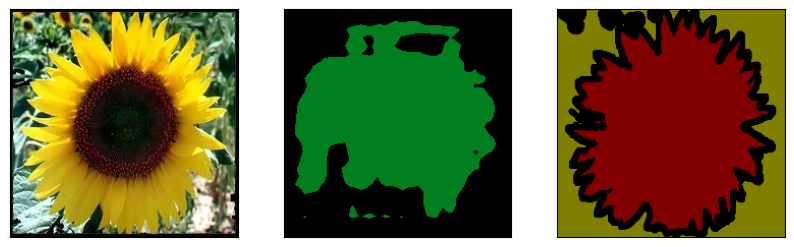

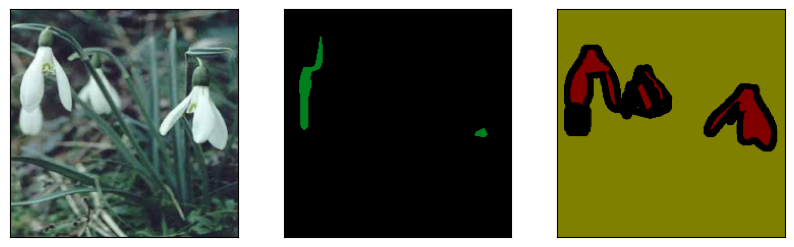

In [20]:
plot_pred(args, model, is_train=True, index_list=[0, 1, 2, 3])

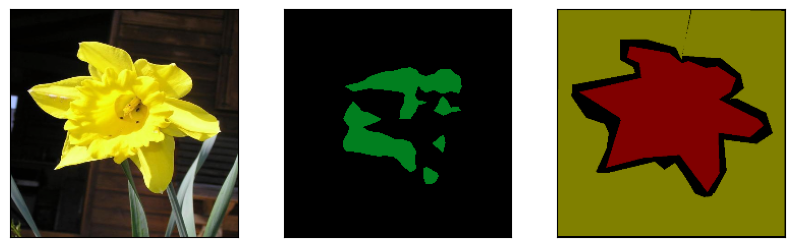

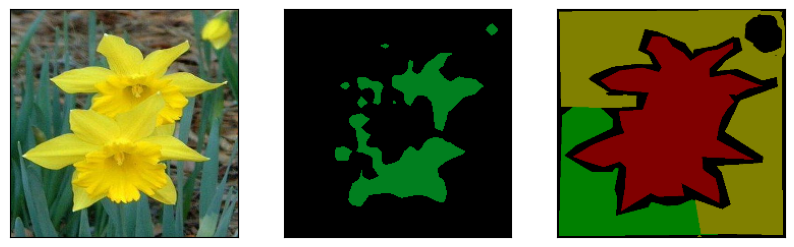

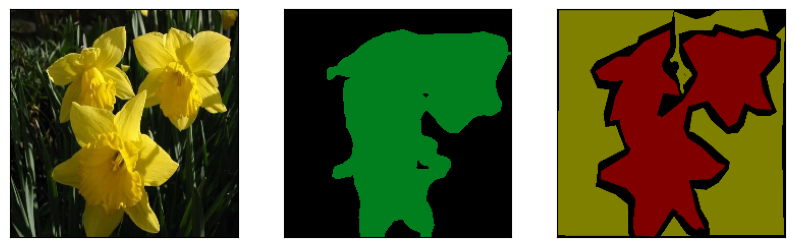

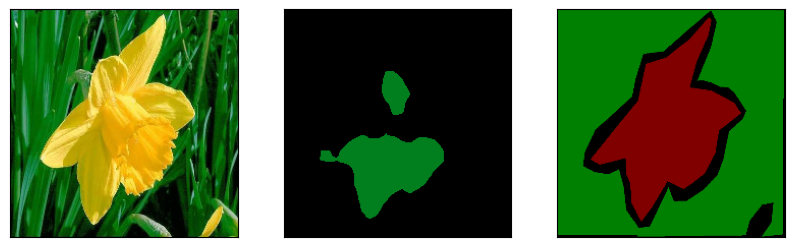

In [21]:
plot_pred(args, model, is_train=False, index_list=[0, 1, 2, 3])

 ## Fine-tune the Semantic Segmentation Model using IoU Loss.

### Question 1.
We will modify the loss function from cross-entropy to the (soft) IoU loss.

Please complete the `compute_iou_loss` function below by adding approximately 5 lines of code at the indicated locations.

In [22]:
def compute_iou_loss(pred, gt, sm=1e-6):
    # Calculate the Intersection over Union (IoU) between the predictions and the ground truth (gt)
    ######################################################
    # Approximately 5 lines of code
    # Hint:
    # - Apply softmax to the predictions along the channel dimension (dim=1)
    # - Focus on computing IoU between the ground truth and the foreground channel of the predictions
    # - No need to consider the IoU for the background channel of the predictions
    # - Extract the foreground from the softmaxed predictions (e.g., softmaxed_pred[:, 1, :, :])
    # - Compute the intersection between the foreground and the ground truth
    # - Compute the union between the foreground and the ground truth
    # - Calculate the loss using the computed intersection and union
    ######################################################
    #############################
    ### Your code starts here ###
    #############################
    softmax_pred = F.softmax(pred, dim=1)
    foreground_pred = softmax_pred[:, 1, :, :]
    intersection = (foreground_pred*gt).sum()
    union = (foreground_pred + gt).sum() - intersection
    iou = intersection / (union + sm)

    return 1 - iou.mean()
    #############################
    ### Your code ends here ###
    #############################

Finish the script below by adding approximately 4 lines of code to train the model.

Train set: 1280, Test set: 212
Beginning training ...


Epoch [1/10]: Loss = 0.6068, Time (seconds) = 49


Epoch [1/10]: Loss = 0.5547, mean IoU = 0.2118, Validation Time (seconds) = 13


Epoch [2/10]: Loss = 0.4932, Time (seconds) = 51


Epoch [2/10]: Loss = 0.4546, mean IoU = 0.2434, Validation Time (seconds) = 12


Epoch [3/10]: Loss = 0.4541, Time (seconds) = 49


Epoch [3/10]: Loss = 0.4447, mean IoU = 0.2509, Validation Time (seconds) = 13
Epoch [4/10]: Loss = 0.4374, Time (seconds) = 50


Epoch [4/10]: Loss = 0.4303, mean IoU = 0.2892, Validation Time (seconds) = 12


Epoch [5/10]: Loss = 0.4221, Time (seconds) = 49


Epoch [5/10]: Loss = 0.4128, mean IoU = 0.3047, Validation Time (seconds) = 12


Epoch [6/10]: Loss = 0.4109, Time (seconds) = 49


Epoch [6/10]: Loss = 0.4090, mean IoU = 0.3142, Validation Time (seconds) = 12
Epoch [7/10]: Loss = 0.4047, Time (seconds) = 49


Epoch [7/10]: Loss = 0.4001, mean IoU = 0.3231, Validation Time (seconds) = 12


Epoch [8/10]: Loss = 0.3969, Time (seconds) = 49


Epoch [8/10]: Loss = 0.3941, mean IoU = 0.3241, Validation Time (seconds) = 12


Epoch [9/10]: Loss = 0.3965, Time (seconds) = 51


Epoch [9/10]: Loss = 0.3855, mean IoU = 0.3373, Validation Time (seconds) = 12


Epoch [10/10]: Loss = 0.3926, Time (seconds) = 49


Epoch [10/10]: Loss = 0.3837, mean IoU = 0.3491, Validation Time (seconds) = 12
Saving model...
Best model attains a mean IoU of: 0.3491


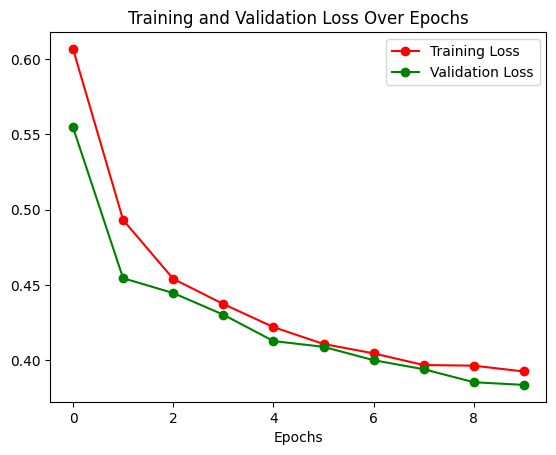

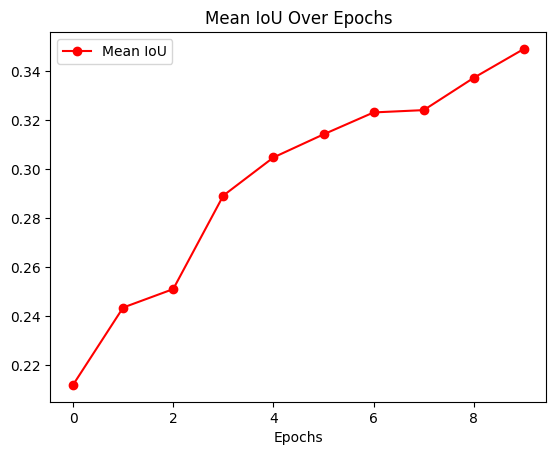

In [23]:
args = AttrDictionary()
# Feel free to experiment with the hyperparameters, but for the purpose of completing the assignment,
# tuning them is not necessary.
args_dict_param = {
    "gpu": True,
    "checkpoint_name": "seg",
    "learning_rate": 0.05,
    "batch_size_train": 128,
    "batch_size_val": 256,
    "epochs": 10,
    "loss": 'm_iou',
    "seed": 0,
    "plot": True,
    "exp_name": "seg",
}
args.update(args_dict_param)

# Remove the last layer and substitute it with a new one.
# To prevent 'CUDA out of memory' errors, you may find it helpful (and sometimes necessary)
# to set `requires_grad=False` for certain layers.
######################################################
# Approximately 4 lines of code
# Hint:
# - Replace the classifier.4 layer with the new Conv2d layer (1 line)
# - You can disregard the aux_classifier module (treat it as irrelevant)
# - Freeze the gradients of the remaining layers (3 lines)
######################################################
#############################
### Your code starts here ###
#############################

# similar as before
for name, param in model.named_parameters():
  if not name.startswith('classifier'): # freeze all parameters except those of last layer
    param.requires_grad = False

model.requires_grad_(False)
model.classifier[4].requires_grad_(True)

train(args, model)

#############################
### Your code ends here ###
#############################


### Question 2.

Run the code below to visualize the predictions.

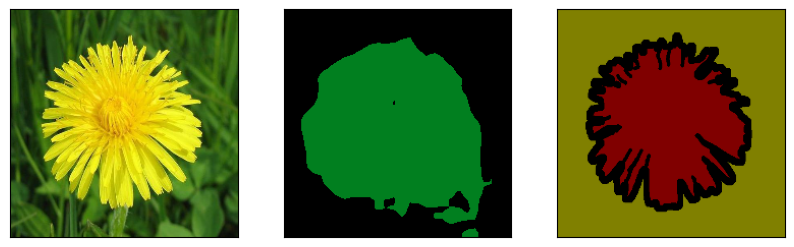

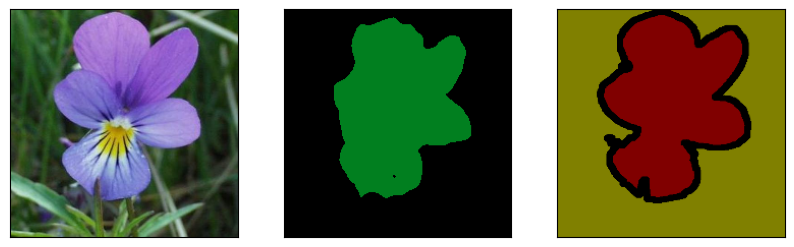

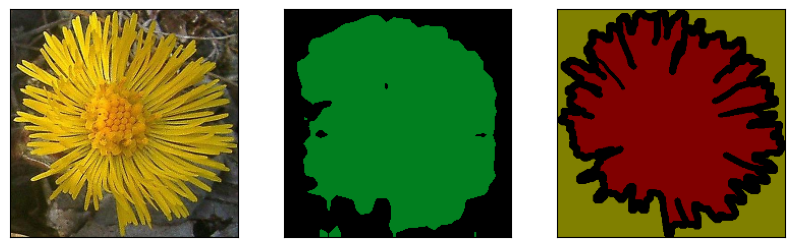

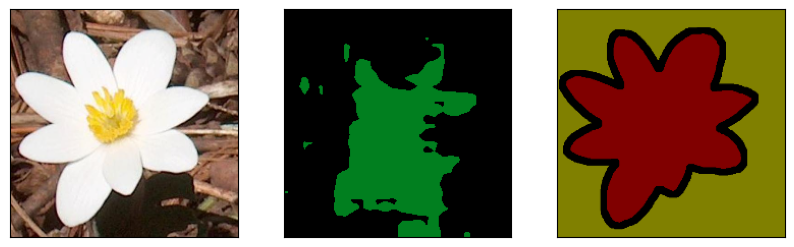

In [24]:
plot_pred(args, model, is_train=True, index_list=[0, 1, 2, 3])

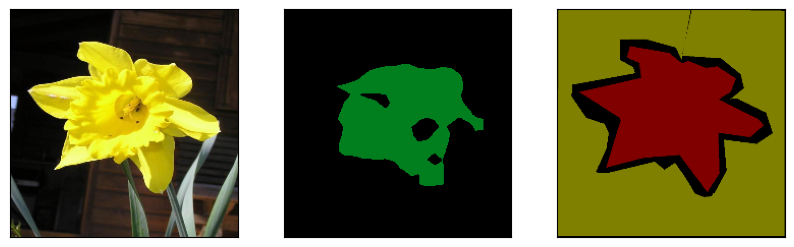

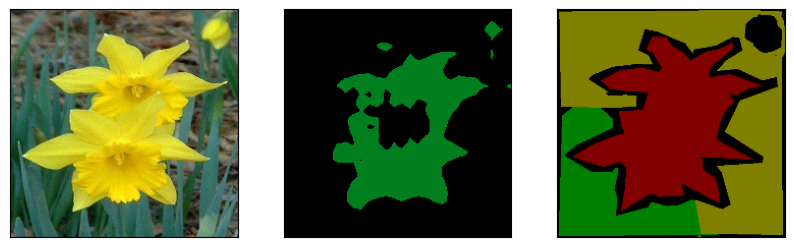

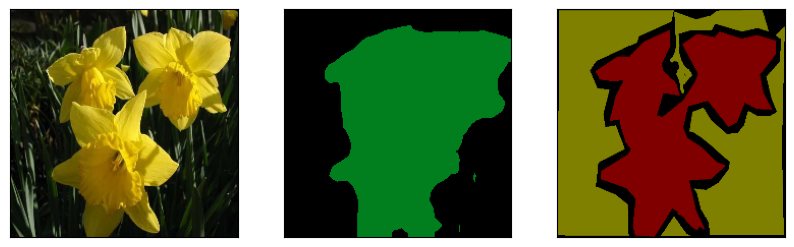

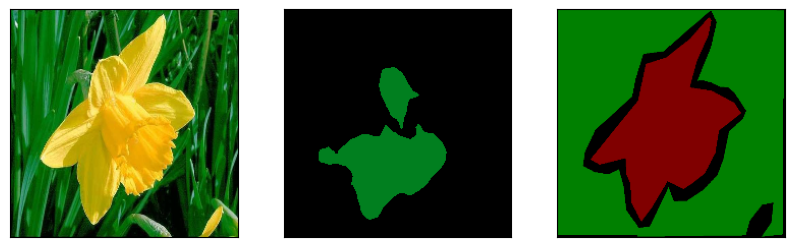

In [25]:
plot_pred(args, model, is_train=False, index_list=[0, 1, 2, 3])

When we performed Segmentation using cross entropy, we didn't get very accurate results. When we switched to IoU loss, which penalizes the objective function based on the intersection of areas between predictions and actual truths, we were able to see very accurate segments that define well our objects.